In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('zinc_prices_IMF.csv')

In [3]:
data.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [4]:
data= data.set_index('Date')

In [5]:
data.head()

,Price
Date,
1-Jan-80,773.82
1-Feb-80,868.62
1-Mar-80,740.75
1-Apr-80,707.68
1-May-80,701.07


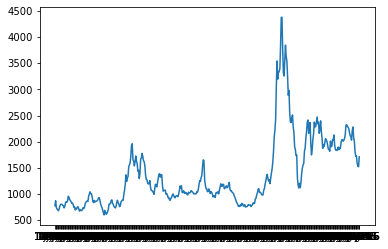

In [6]:
plt.plot(data)

In [7]:
ts=data['Price']

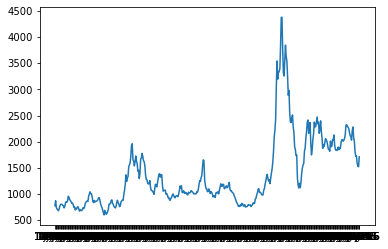

In [8]:
plt.plot(ts)

In [9]:
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller,acf,pacf

In [10]:
def stationarity(timeseries):
    rolmean=timeseries.rolling(center=False,window=51).mean()
    rolstd=timeseries.rolling(center=False,window=51).std()
    
    orig=plt.plot(timeseries,color='red',label='Original')
    mean=plt.plot(rolmean,color='blue',label='mean')
    std=plt.plot(rolstd,color='grey',label='std')
    
    plt.legend(loc='best')
    plt.title('IMF Commodity Price Forecast')
    plt.show(block=False)
    
    print('Results Of DIckey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test statistics','p value','#lags used','no of obs used'])
    
    for key,value in dftest[4].items():
        dfoutput['critical values (%s)'%key] = value
    print(dfoutput)    

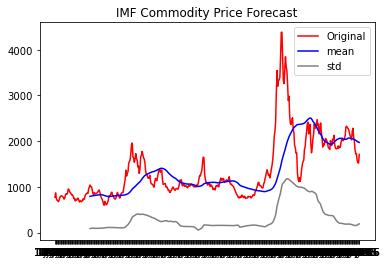

Results Of DIckey-Fuller Test:
Test statistics           -3.139601
p value                    0.023758
#lags used                 7.000000
no of obs used           426.000000
critical values (1%)      -3.445794
critical values (5%)      -2.868349
critical values (10%)     -2.570397
dtype: float64


In [11]:
stationarity(data['Price'])

In [12]:
ts_log = np.log(ts)

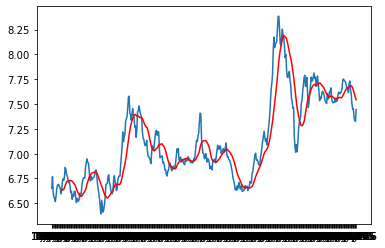

In [13]:
movingavg=ts_log.rolling(window=15).mean()
movingstd=ts_log.rolling(window=15).std()
plt.plot(ts_log)
plt.plot(movingavg,color='red')

In [14]:
ts_log_mv_diff=ts_log- movingavg
ts_log_mv_diff.head()
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Date
1-Mar-81   -0.002691
1-Apr-81    0.079611
1-May-81    0.112554
1-Jun-81    0.091140
1-Jul-81    0.106280
1-Aug-81    0.185178
1-Sep-81    0.144844
1-Oct-81    0.079259
1-Nov-81    0.052990
1-Dec-81    0.018012
Name: Price, dtype: float64

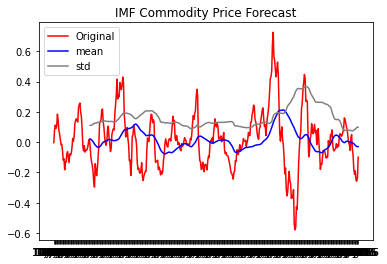

Results Of DIckey-Fuller Test:
Test statistics           -5.347496
p value                    0.000004
#lags used                 4.000000
no of obs used           415.000000
critical values (1%)      -3.446206
critical values (5%)      -2.868530
critical values (10%)     -2.570493
dtype: float64


In [15]:
stationarity(ts_log_mv_diff)

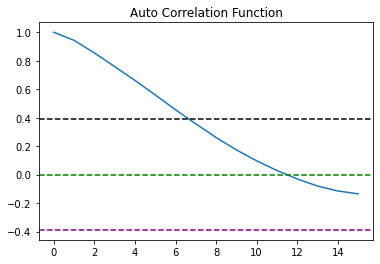

In [16]:
plt.plot(np.arange(0,16),acf(ts_log_mv_diff,nlags=15))
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='purple')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='black')
plt.title('Auto Correlation Function')
plt.show()

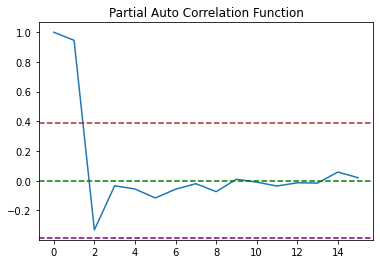

In [17]:
plt.plot(np.arange(0,16),pacf(ts_log_mv_diff,nlags=15))
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='purple')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='brown')
plt.title('Partial Auto Correlation Function')
plt.show()

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'rss:  nan')

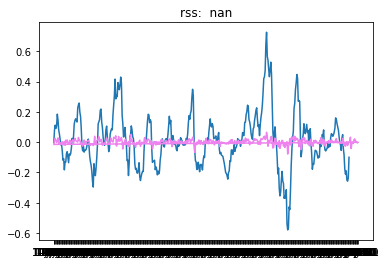

In [18]:
model=ARIMA(ts_log,order=(1,1,0))
model_res=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(model_res.fittedvalues,color='violet')
plt.title('rss: %4f'%sum((model_res.fittedvalues[1:]-ts_log_mv_diff)**2))

In [19]:
pred_ar_diff=pd.Series(model_res.fittedvalues, copy=True)
pred_ar_diff.head()

Date
1-Feb-80    0.002030
1-Mar-80    0.033049
1-Apr-80   -0.042031
1-May-80   -0.011002
1-Jun-80   -0.001089
dtype: float64

In [20]:
pred_ar_diff_cumsum= pred_ar_diff.cumsum()
pred_ar_diff_cumsum.head()

Date
1-Feb-80    0.002030
1-Mar-80    0.035079
1-Apr-80   -0.006952
1-May-80   -0.017955
1-Jun-80   -0.019043
dtype: float64

In [23]:
pred_ar_log= pd.Series(ts_log.iloc[0], index=ts_log.index)
pred_ar_log= pred_ar_log.add(pred_ar_diff_cumsum,fill_value=0)
pred_ar_log.head()

Date
1-Apr-00    7.109677
1-Apr-01    7.099662
1-Apr-02    7.061615
1-Apr-03    7.069249
1-Apr-04    7.177725
dtype: float64

Text(0.5, 1.0, 'rmse: 2160.8844')

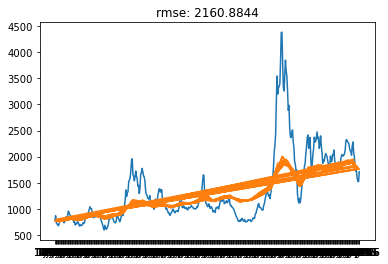

In [24]:
predd_arima=np.exp(pred_ar_log)
plt.plot(ts)
plt.plot(predd_arima)
plt.title('rmse: %.4f'%np.sqrt((sum(predd_arima-ts)**2)/len(ts)))